In [ ]:
# 1 Imports
import pandas as pd
import numpy as np
from keras import Sequential
from keras import layers
from keras.models import clone_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
import matplotlib.pyplot as plt

In [2]:
# 2 Load Datasets
df_nlr = pd.read_csv("raw_nuclear/nlr.csv")
df_ura = pd.read_csv("raw_nuclear/ura.csv")
df_crak = pd.read_csv("raw_oil_and_gas/crak.csv")
df_fcg = pd.read_csv("raw_oil_and_gas/fcg.csv")
df_pxe = pd.read_csv("raw_oil_and_gas/pxe.csv")
df_icln = pd.read_csv("raw_renewable/icln.csv")
df_smog = pd.read_csv("raw_renewable/smog.csv")
df_tan = pd.read_csv("raw_renewable/tan.csv")

repaired_col = "Repaired?"
df_nlr = df_nlr.drop(columns=[repaired_col]).fillna(0)
df_ura = df_ura.drop(columns=[repaired_col]).fillna(0)
df_crak = df_crak.drop(columns=[repaired_col]).fillna(0)
df_fcg = df_fcg.drop(columns=[repaired_col]).fillna(0)
df_pxe = df_pxe.drop(columns=[repaired_col]).fillna(0)
df_icln = df_icln.drop(columns=[repaired_col]).fillna(0)
df_smog = df_smog.drop(columns=[repaired_col]).fillna(0)
df_tan = df_tan.drop(columns=[repaired_col]).fillna(0)

df_nlr = df_nlr.drop(columns=["Date"]).fillna(0)
df_ura = df_ura.drop(columns=["Date"]).fillna(0)
df_crak = df_crak.drop(columns=["Date"]).fillna(0)
df_fcg = df_fcg.drop(columns=["Date"]).fillna(0)
df_pxe = df_pxe.drop(columns=["Date"]).fillna(0)
df_icln = df_icln.drop(columns=["Date"]).fillna(0)
df_smog = df_smog.drop(columns=["Date"]).fillna(0)
df_tan = df_tan.drop(columns=["Date"]).fillna(0)

In [ ]:
# 3 Create time frame based subsets
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

def time_based_subsets(df):
    subsets = []
    #row 2013 is the last date of 2023, 12/29/2023
    #row 756 is start of 2019
    #row 505 is start of 2018
    #row 254 is start of 2017
    #row 2 is start of 2016
    #all of these -2 bc 0 indexing and bc title row already seperated out in pd df
    subsets.append(df[0:2012]) #8 year time frame
    subsets.append(df[252:2012]) #7 year time frame
    subsets.append(df[503:2012]) #6 year time frame
    subsets.append(df[754:2012]) #5 year time frame
    subsets.append(df[2012:2262]) # 2024 only
    X, y = [], []
    x1, y1 = create_sequences(subsets[0], 30)
    x1 = x1.reshape((x1.shape[0], x1.shape[1], 6))
    x2, y2 = create_sequences(subsets[1], 30)
    x2 = x2.reshape((x2.shape[0], x2.shape[1], 6))
    x3, y3 = create_sequences(subsets[2], 30)
    x3 = x3.reshape((x3.shape[0], x3.shape[1], 6))
    x4, y4 = create_sequences(subsets[3], 30)
    x4 = x4.reshape((x4.shape[0], x4.shape[1], 6))
    x5, y5 = create_sequences(subsets[4], 30)
    x5 = x5.reshape((x5.shape[0], x5.shape[1], 6))
    X.append(x1)
    X.append(x2)
    X.append(x3)
    X.append(x4)
    X.append(x5)
    y.append(y1)
    y.append(y2)
    y.append(y3)
    y.append(y4)
    y.append(y5)
    return subsets, X, y

scaler1 = StandardScaler()
scaled_nlr = scaler1.fit_transform(df_nlr)
nlr_sets, nlr_X, nlr_y = time_based_subsets(scaled_nlr)
scaler2 = StandardScaler()
scaled_ura = scaler2.fit_transform(df_ura)
ura_sets, ura_X, ura_y = time_based_subsets(scaled_ura)
scaler3 = StandardScaler()
scaled_crak = scaler3.fit_transform(df_crak)
crak_sets, crak_X, crak_y = time_based_subsets(scaled_crak)
scaler4 = StandardScaler()
scaled_fcg = scaler4.fit_transform(df_fcg)
fcg_sets, fcg_X, fcg_y = time_based_subsets(scaled_fcg)
scaler5 = StandardScaler()
scaled_pxe = scaler5.fit_transform(df_pxe)
pxe_sets, pxe_X, pxe_y = time_based_subsets(scaled_pxe)
scaler6 = StandardScaler()
scaled_icln = scaler6.fit_transform(df_icln)
icln_sets, icln_X, icln_y = time_based_subsets(scaled_icln)
scaler7 = StandardScaler()
scaled_smog = scaler7.fit_transform(df_smog)
smog_sets, smog_X, smog_y = time_based_subsets(scaled_smog)
scaler8 = StandardScaler()
scaled_tan = scaler8.fit_transform(df_tan)
tan_sets, tan_X, tan_y = time_based_subsets(scaled_tan)
'''combined_X, combined_y = [], []
combined_X.append(np.concatenate((nlr_X[0], ura_X[0])))
combined_X.append(np.concatenate((nlr_X[1], ura_X[1])))
combined_X.append(np.concatenate((nlr_X[2], ura_X[2])))
combined_X.append(np.concatenate((nlr_X[3], ura_X[3])))
combined_X.append(np.concatenate((nlr_X[4], ura_X[4])))
combined_y.append(np.concatenate((nlr_y[0], ura_y[0])))
combined_y.append(np.concatenate((nlr_y[1], ura_y[1])))
combined_y.append(np.concatenate((nlr_y[2], ura_y[2])))
combined_y.append(np.concatenate((nlr_y[3], ura_y[3])))
combined_y.append(np.concatenate((nlr_y[4], ura_y[4])))'''


'crak_sets, crak_X, crak_y = time_based_subsets(df_crak)\nfcg_sets, fcg_X, fcg_y = time_based_subsets(df_fcg)\npxe_sets, pxe_X, pxe_y = time_based_subsets(df_pxe)\nicln_sets, icln_X, icln_y = time_based_subsets(df_icln)\nsmog_sets, smog_X, smog_y = time_based_subsets(df_smog)\ntan_sets, tan_X, tan_y = time_based_subsets(df_tan)'

In [5]:
# 4 Initial Model Setup
sequence_length = 30
lstm_model = Sequential()
lstm_model.add(layers.LSTM(units=128, return_sequences=True, input_shape=(sequence_length, 6)))
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.LSTM(units=64, return_sequences=False))
lstm_model.add(layers.Dense(units=32, activation='relu'))
lstm_model.add(layers.Dense(units=6))
lstm_model.compile(optimizer='adam', loss='mse')

C:\Users\david\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
# 5 Model Training
lstm_nlr = clone_model(lstm_model)
lstm_nlr.compile(optimizer='adam',loss='mse')
lstm_ura = clone_model(lstm_model)
lstm_ura.compile(optimizer='adam',loss='mse')
lstm_crak = clone_model(lstm_model)
lstm_crak.compile(optimizer='adam',loss='mse')
lstm_fcg = clone_model(lstm_model)
lstm_fcg.compile(optimizer='adam',loss='mse')
lstm_pxe = clone_model(lstm_model)
lstm_pxe.compile(optimizer='adam',loss='mse')
lstm_icln = clone_model(lstm_model)
lstm_icln.compile(optimizer='adam',loss='mse')
lstm_smog = clone_model(lstm_model)
lstm_smog.compile(optimizer='adam',loss='mse')
lstm_tan = clone_model(lstm_model)
lstm_tan.compile(optimizer='adam',loss='mse')
lstm_nlr.fit(
    nlr_X[0], nlr_y[0],
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)
lstm_ura.fit(
    ura_X[0], ura_y[0],
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)
lstm_crak.fit(
    crak_X[0], crak_y[0],
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)
lstm_fcg.fit(
    fcg_X[0], fcg_y[0],
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)
lstm_pxe.fit(
    pxe_X[0], pxe_y[0],
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)
lstm_icln.fit(
    icln_X[0], icln_y[0],
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)
lstm_smog.fit(
    smog_X[0], smog_y[0],
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)
lstm_tan.fit(
    tan_X[0], tan_y[0],
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)
'''lstm_combined.fit(
    combined_X[0], combined_y[0],
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)'''

Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.1139 - val_loss: 0.6155
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0092 - val_loss: 0.5056
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0083 - val_loss: 0.4486
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0062 - val_loss: 0.4287
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0062 - val_loss: 0.4004
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0053 - val_loss: 0.3697
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0048 - val_loss: 0.3587
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0051 - val_loss: 0.3560
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0043 - val_loss: 0.3709
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0047 - val_loss: 0.3146
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0040 - val_loss: 0.3167
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

'lstm_combined.fit(\n    combined_X[0], combined_y[0],\n    epochs=100,\n    batch_size=32,\n    validation_split=0.1,\n    verbose=1\n)'

In [7]:
# 6 make predictions
# this receives a list of models, and it will take the average of their predictions
# it can also be passed a single model
def predict_future_points(models,last_seq, scaler, num_predictions=20):
    current_sequence = np.array(last_seq)

    current_sequence = current_sequence.reshape(1, current_sequence.shape[0], current_sequence.shape[1])

    predictions = []

    for _ in range(num_predictions):
        next_pred_sum = []
        next_pred_scaled_sum = []
        for i in range(len(models)):
            next_pred_scaled = models[i].predict(current_sequence, verbose=0)
            next_pred = scaler.inverse_transform(next_pred_scaled)
            next_pred_scaled_sum.append(next_pred_scaled)
            next_pred_sum.append(next_pred)
        next_pred_average = np.zeros(next_pred_sum[0].shape)
        next_pred_scaled_average = np.zeros(next_pred_scaled_sum[0].shape)
        for j in range(len(next_pred_sum[0][0])):
            for k in range(len(next_pred_sum)):
                next_pred_average[0][j] += next_pred_sum[k][0][j] #add value of all models for each value before going to next val
                next_pred_scaled_average[0][j] += next_pred_scaled_sum[k][0][j]
            next_pred_average[0][j] = next_pred_average[0][j]/len(next_pred_sum)
            next_pred_scaled_average[0][j] = next_pred_scaled_average[0][j]/len(next_pred_sum)
        predictions.append(next_pred_average)

        current_sequence = np.concatenate(
            [current_sequence[:,1:,:], [next_pred_scaled_average]], axis=1
        )


    return predictions

last_seq1 = nlr_sets[0][-30:]
future1 = predict_future_points([lstm_nlr],last_seq1, scaler1, 250)
last_seq2 = ura_sets[0][-30:]
future2 = predict_future_points([lstm_ura],last_seq2, scaler2, 250)
last_seq3 = crak_sets[0][-30:]
future3 = predict_future_points([lstm_crak],last_seq3, scaler3, 250)
last_seq4 = fcg_sets[0][-30:]
future4 = predict_future_points([lstm_fcg],last_seq4, scaler4, 250)
last_seq5 = pxe_sets[0][-30:]
future5 = predict_future_points([lstm_pxe],last_seq5, scaler5, 250)
last_seq6 = icln_sets[0][-30:]
future6 = predict_future_points([lstm_icln],last_seq6, scaler6, 250)
last_seq7 = smog_sets[0][-30:]
future7 = predict_future_points([lstm_smog],last_seq7, scaler7, 250)
last_seq8 = tan_sets[0][-30:]
future8 = predict_future_points([lstm_tan],last_seq8, scaler8, 250)


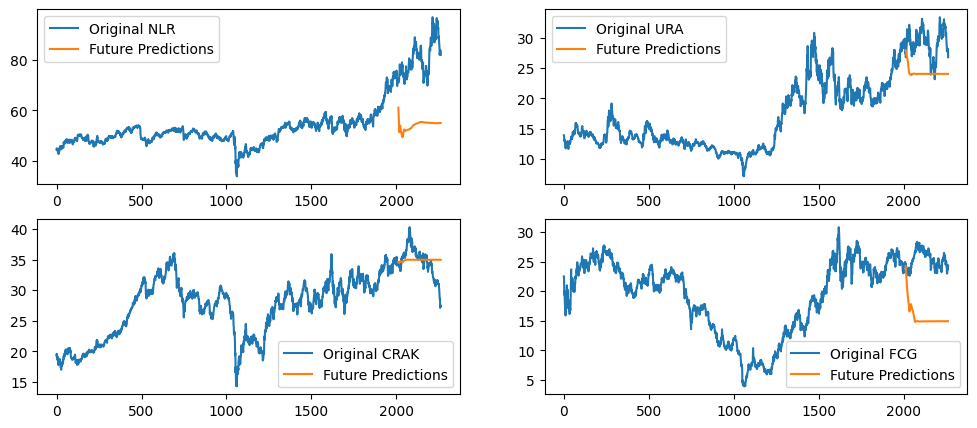

In [ ]:
# 7 Show Results part 1
plt.figure(figsize=(12,5))
future_feature1 = np.array([arr[0][3] for arr in future1])
future_feature2 = np.array([arr[0][3] for arr in future2])
future_feature3 = np.array([arr[0][3] for arr in future3])
future_feature4 = np.array([arr[0][3] for arr in future4])
future_feature5 = np.array([arr[0][3] for arr in future5])
future_feature6 = np.array([arr[0][3] for arr in future6])
future_feature7 = np.array([arr[0][3] for arr in future7])
future_feature8 = np.array([arr[0][3] for arr in future8])
plt.subplot(2, 2, 1)
plt.plot(df_nlr['Close'], label="Original NLR")
plt.plot(range(2012, 2012 + len(future1)), future_feature1, label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(df_ura['Close'], label="Original URA")
plt.plot(range(2012, 2012 + len(future2)), future_feature2, label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(df_crak['Close'], label="Original CRAK")
plt.plot(range(2012, 2012 + len(future3)), future_feature3, label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(df_fcg['Close'], label="Original FCG")
plt.plot(range(2012, 2012 + len(future4)), future_feature4, label="Future Predictions")
plt.legend()

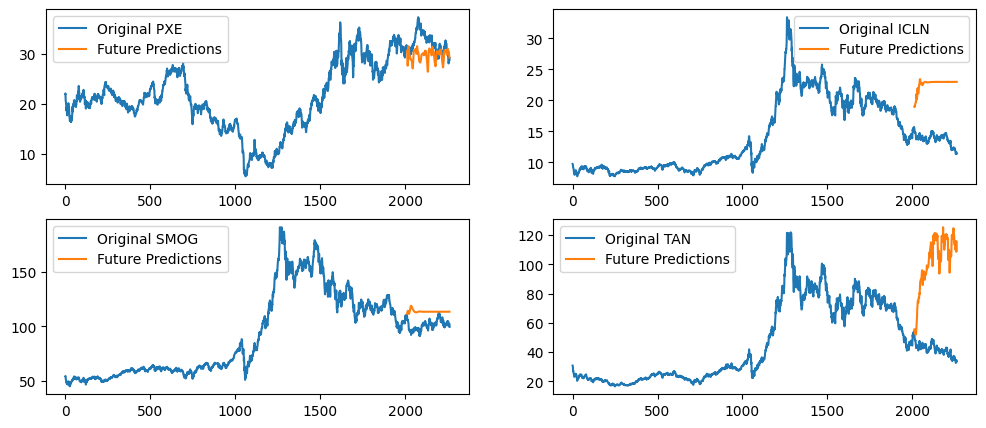

In [9]:
# 8 Show Results part 2
plt.figure(figsize=(12,5))
plt.subplot(2, 2, 1)
plt.plot(df_pxe['Close'], label="Original PXE")
plt.plot(range(2012, 2012 + len(future5)), future_feature5, label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(df_icln['Close'], label="Original ICLN")
plt.plot(range(2012, 2012 + len(future6)), future_feature6, label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(df_smog['Close'], label="Original SMOG")
plt.plot(range(2012, 2012 + len(future7)), future_feature7, label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(df_tan['Close'], label="Original TAN")
plt.plot(range(2012, 2012 + len(future8)), future_feature8, label="Future Predictions")
plt.legend()

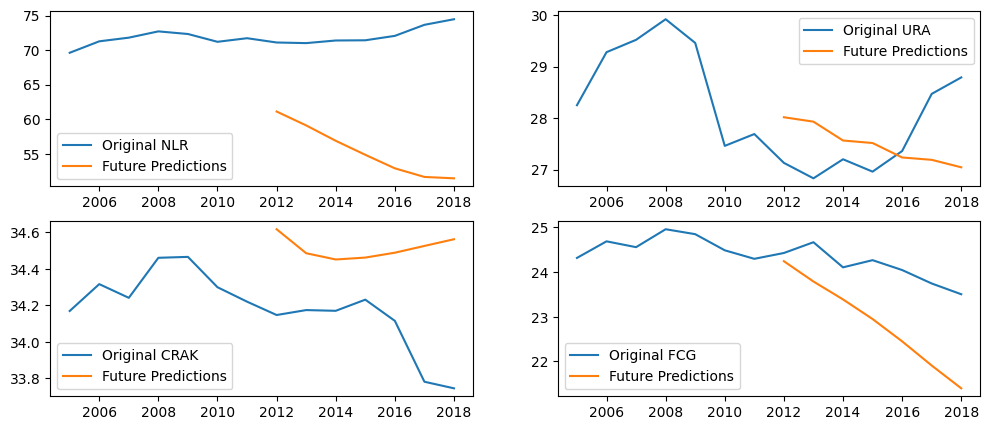

In [10]:
# 9 Show Results part 3
plt.figure(figsize=(12,5))
plt.subplot(2, 2, 1)
plt.plot(df_nlr['Close'].iloc[2005:2019], label="Original NLR")
plt.plot(range(2012, 2012 + 7), future_feature1[0:7], label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(df_ura['Close'].iloc[2005:2019], label="Original URA")
plt.plot(range(2012, 2012 + 7), future_feature2[0:7], label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(df_crak['Close'].iloc[2005:2019], label="Original CRAK")
plt.plot(range(2012, 2012 + 7), future_feature3[0:7], label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(df_fcg['Close'].iloc[2005:2019], label="Original FCG")
plt.plot(range(2012, 2012 + 7), future_feature4[0:7], label="Future Predictions")
plt.legend()

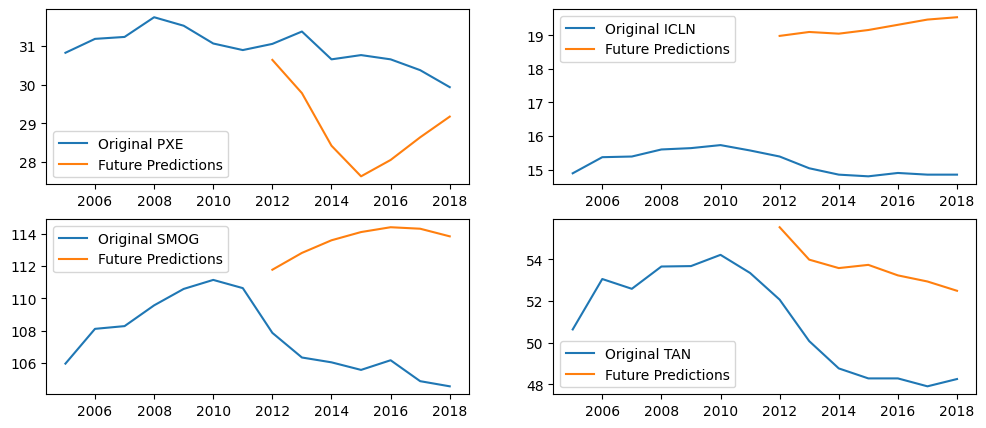

In [11]:
# 10 Show Results part 4
plt.figure(figsize=(12,5))
plt.subplot(2, 2, 1)
plt.plot(df_pxe['Close'].iloc[2005:2019], label="Original PXE")
plt.plot(range(2012, 2012 + 7), future_feature5[0:7], label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(df_icln['Close'].iloc[2005:2019], label="Original ICLN")
plt.plot(range(2012, 2012 + 7), future_feature6[0:7], label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(df_smog['Close'].iloc[2005:2019], label="Original SMOG")
plt.plot(range(2012, 2012 + 7), future_feature7[0:7], label="Future Predictions")
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(df_tan['Close'].iloc[2005:2019], label="Original TAN")
plt.plot(range(2012, 2012 + 7), future_feature8[0:7], label="Future Predictions")
plt.legend()